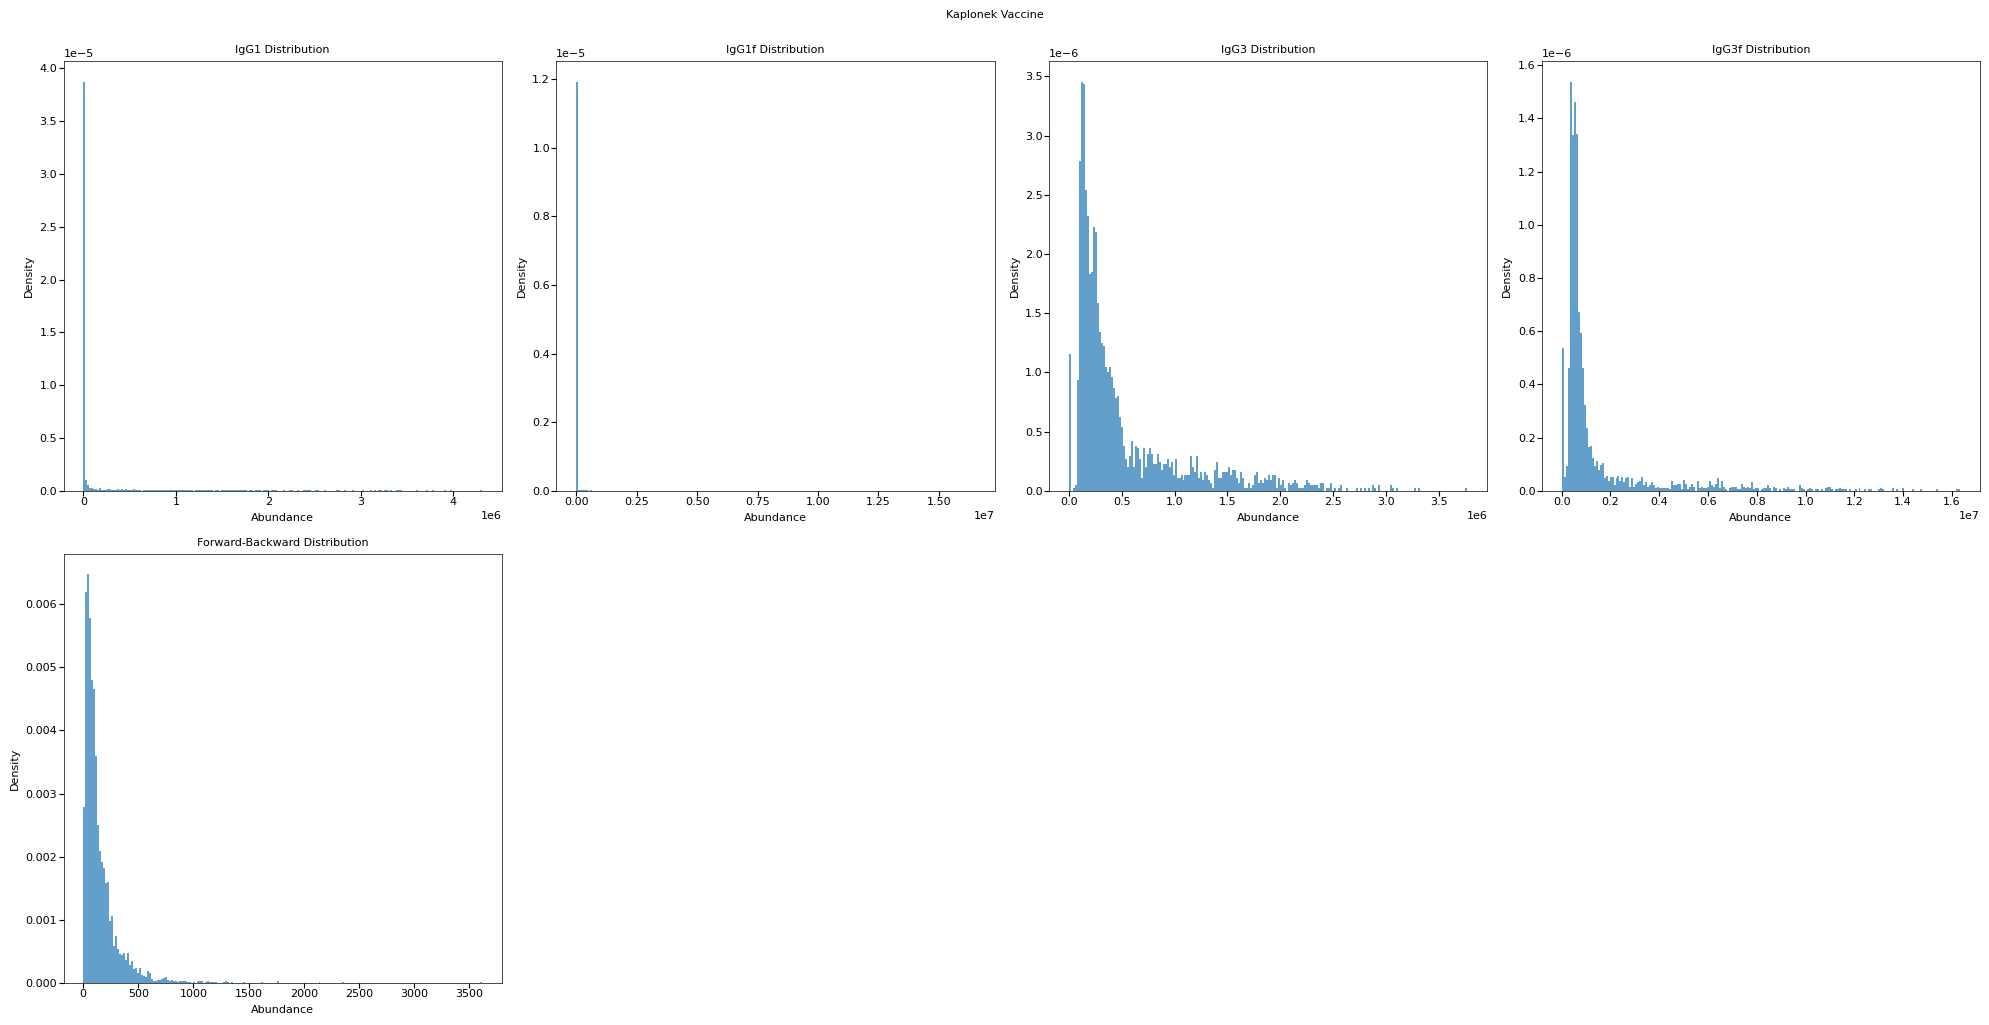

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from maserol.figures.common import CACHE_DIR
from maserol.figures.figure_4 import ALTER_RTOT_CACHE_PATH
from maserol.figures.figure_5 import (
    KAPLONEK_VACCINE_RTOT_CACHE_PATH,
    ZOHAR_RTOT_CACHE_PATH,
)
from maserol.forward_backward import generate_rtot_distribution


def load_and_plot_distributions(antibody_path, n_samples=1000, n_bins=200):
    """
    Load antibody abundances from a specified path, plot their distribution
    separated by antibody type, and plot the forward-backward antibody distribution.

    Args:
    antibody_path (str): Path to the CSV file containing antibody abundances.
    n_samples (int): Number of samples to generate for the forward-backward distribution.
    """
    # Load antibody abundances
    antibody_df = (
        pd.read_csv(antibody_path)
        .reset_index(drop=True)
        .set_index(["Sample", "Antigen"])
    )

    # Plot histograms of the input dataset for each antibody type
    antibodies = antibody_df.columns
    fig, axes = plt.subplots(2, len(antibodies), figsize=(5 * len(antibodies), 10))

    for i, antibody in enumerate(antibodies):
        ax = axes[0, i]
        ax.hist(
            antibody_df[antibody],
            bins=n_bins,
            density=True,
            alpha=0.7,
        )
        ax.set_title(f"{antibody} Distribution")
        ax.set_xlabel("Abundance")
        ax.set_ylabel("Density")

    # Generate and plot histograms of the forward-backward distribution for each antibody species
    fb_distribution = generate_rtot_distribution(n_samples)

    ax = axes[1, 0]  # Use only the first subplot in the second row
    ax.hist(fb_distribution.flatten(), bins=n_bins, density=True, alpha=0.7)
    ax.set_title("Forward-Backward Distribution")
    ax.set_xlabel("Abundance")
    ax.set_ylabel("Density")

    # Hide the unused subplots in the second row
    for i in range(1, len(antibodies)):
        axes[1, i].set_visible(False)

    plt.tight_layout()


# Example usage:
# load_and_plot_distributions(ZOHAR_RTOT_CACHE_PATH)
load_and_plot_distributions(KAPLONEK_VACCINE_RTOT_CACHE_PATH)
# load_and_plot_distributions(ALTER_RTOT_CACHE_PATH)

# set the overall title, making sure it is high enough that it doesn't get cut off
plt.suptitle("Alter", y=1.02)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


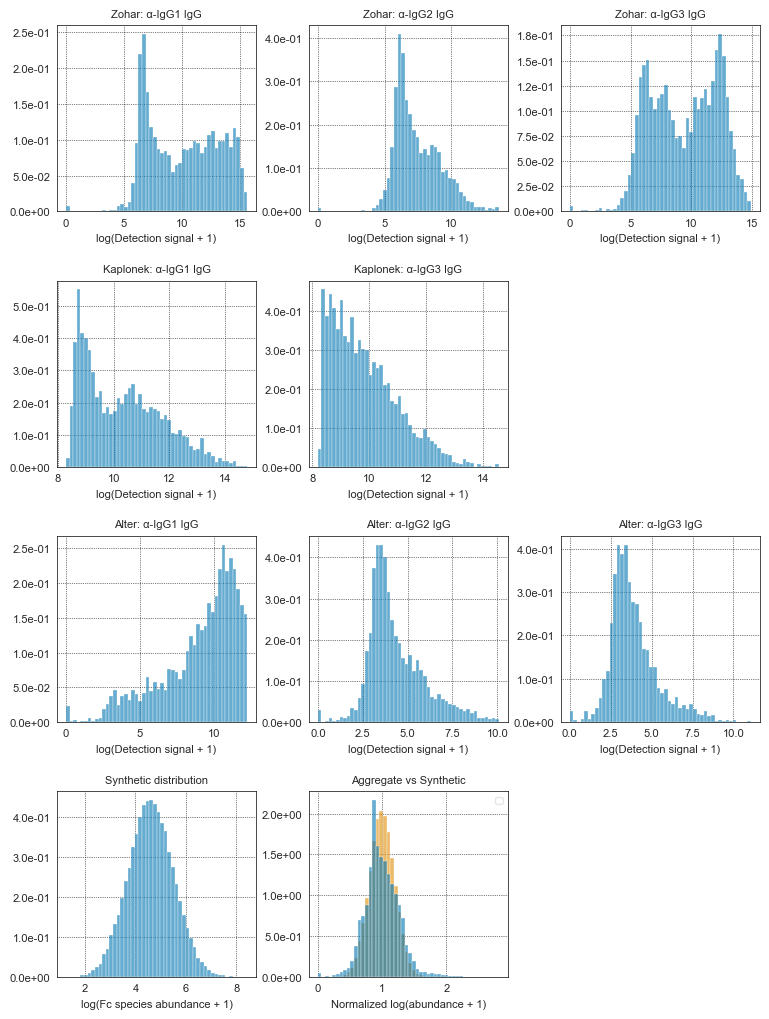

In [56]:
import re
from maserol.datasets import Alter, KaplonekVaccine, Zohar
from maserol.figures.common import Multiplot
import seaborn as sns
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_dataset_distributions(n_bins: int = 50):
    """
    Plot distributions of anti-antibody detection for all datasets and forward-backward on separate rows.

    Args:
    n_bins (int): Number of bins for the histograms
    """
    datasets = {
        "Zohar": Zohar(),
        "KaplonekVaccine": KaplonekVaccine(),
        "Alter": Alter(),
    }
    name_mapping = {
        "Zohar": "Zohar",
        "KaplonekVaccine": "Kaplonek",
        "Alter": "Alter",
    }

    # Set up the color palette
    colors = sns.color_palette("deep")
    antibody_color = colors[0]
    fb_color = colors[1]
    alpha = 0.6

    def filter_ligands(ligands):
        return [
            lig for lig in ligands if re.match("^igg[1-3]", lig, flags=re.IGNORECASE)
        ]

    # Count number of subplots needed for each dataset after filtering
    dataset_subplots = {
        name: len(
            filter_ligands(
                dataset.get_detection_signal(select_ligs=False).Ligand.values
            )
        )
        for name, dataset in datasets.items()
    }

    n_rows = (
        len(datasets) + 1
    )  # One row per dataset + one row for forward-backward and aggregate
    n_cols = max(
        dataset_subplots.values()
    )  # Use the maximum number of filtered ligands as column count

    plot = Multiplot((n_cols, n_rows), fig_size=(7.5, 10))

    all_normalized_data = []

    for row, (dataset_name, dataset) in enumerate(datasets.items()):
        detection_signal = dataset.get_detection_signal(select_ligs=False)
        filtered_ligands = filter_ligands(detection_signal.Ligand.values)
        detection_signal = detection_signal.sel(Ligand=filtered_ligands)

        for col, ligand in enumerate(filtered_ligands):
            ax = plot.axes[row * n_cols + col]
            ligand_data = detection_signal.sel(Ligand=ligand).values.flatten()

            # Apply log(x+1) transformation
            log_data = np.log1p(ligand_data)

            # Normalize the log-transformed data
            normalized_data = log_data / np.mean(log_data)
            all_normalized_data.extend(normalized_data)

            sns.histplot(
                log_data,
                bins=n_bins,
                stat="density",
                kde=False,
                alpha=alpha,
                palette=[antibody_color],
                ax=ax,
            )
            ax.set_title(f"{name_mapping[dataset_name]}: α-{ligand} IgG")
            ax.set_xlabel("log(Detection signal + 1)")
            ax.set_ylabel("")

        # Hide any unused subplots in this row
        for col in range(len(filtered_ligands), n_cols):
            plot.axes[row * n_cols + col].set_visible(False)

    # Generate and plot histogram of the forward-backward distribution on the last row
    fb_distribution = generate_rtot_distribution(10000)  # Using 10000 samples

    # Apply log(x+1) transformation to the synthetic data
    log_fb_distribution = np.log1p(fb_distribution)

    # Normalize the log-transformed synthetic data
    normalized_fb_distribution = log_fb_distribution.flatten() / np.mean(
        log_fb_distribution
    )

    ax = plot.axes[-n_cols]  # Use the first subplot of the last row
    sns.histplot(
        log_fb_distribution.flatten(),
        bins=n_bins,
        stat="density",
        kde=False,
        alpha=alpha,
        palette=[fb_color],
        label="Synthetic",
        ax=ax,
    )
    ax.set_title("Synthetic distribution")
    ax.set_xlabel("log(Fc species abundance + 1)")
    ax.set_ylabel("")

    # Plot the aggregate distribution
    ax = plot.axes[-n_cols + 1]  # Use the second subplot of the last row

    # Create a DataFrame for seaborn
    df = pd.DataFrame(
        {
            "value": np.concatenate([all_normalized_data, normalized_fb_distribution]),
            "type": ["Aggregate"] * len(all_normalized_data)
            + ["Synthetic"] * len(normalized_fb_distribution),
        }
    )

    # Use seaborn to plot both distributions
    sns.histplot(
        data=df,
        x="value",
        hue="type",
        stat="density",
        common_norm=False,
        alpha=alpha,
        bins=n_bins,
        ax=ax,
        # palette=[aggregate_color, fb_color],
    )

    ax.set_title("Aggregate vs Synthetic")
    ax.set_xlabel("Normalized log(abundance + 1)")
    ax.set_ylabel("")
    # Remove legend title
    ax.legend(title='')

    # Hide any unused subplots in the last row
    for col in range(2, n_cols):
        plot.axes[-n_cols + col].set_visible(False)

    # Set y-axis to scientific notation with 2 significant figures
    for ax in plot.axes:
        ax.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
        ax.yaxis.get_major_formatter().set_scientific(True)
        ax.yaxis.get_major_formatter().set_powerlimits((0, 0))
        ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)
        ax.yaxis.get_offset_text().set_fontsize(8)

        # Set to 2 significant figures
        @plt.FuncFormatter
        def sci_formatter(x, p):
            return f"{x:.1e}"

        ax.yaxis.set_major_formatter(sci_formatter)

    plot.fig.tight_layout(pad=0, w_pad=0.3, h_pad=1.5)


# Example usage:
plot_dataset_distributions()